In [ ]:
!pip install scikit-image pystackreg

In [1]:
import numpy as np
import scipy as sc
from skimage import io, transform
from skimage.restoration import wiener
import matplotlib.pyplot as plt
from pystackreg import StackReg

In [2]:
def gaussian_filter(shape, sigma):
    cm,cn = [(dim-1)//2 for dim in shape]
    rm = np.array(range(shape[0]))-cm
    rn = np.array(range(shape[1]))-cn
    a = 2*sigma**2
    x = np.exp(-(rm**2)/a).reshape(shape[0],1)
    y = np.exp(-(rn**2)/a).reshape(1,shape[1])
    filter = np.dot(x,y)/(np.pi*a)
    return filter

In [116]:
n_img = 20
n_iter = 70
scale = 3
beta = 0.6
lam = 0.05
img_dir = ''
ext = '.bmp'
imgs = []
for i in range(n_img):
    imgs.append(io.imread(img_dir+str(i+1)+ext))
imgs = np.array(imgs)

9


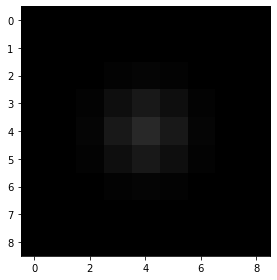

In [117]:
kern = np.int(np.round(np.max(imgs[0].shape)*lam*scale))
print(kern)
blur = gaussian_filter((kern,kern), 1)
io.imshow(blur)
io.show()
dblimg = wiener(imgs[0],blur,balance=0)
# io.imshow(dblimg)
# io.show()

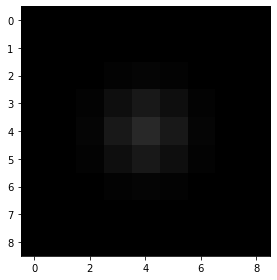

In [129]:
blrft = np.fft.fftshift(np.fft.fft2(imgs[0]))/np.fft.fftshift(np.fft.fft2(dblimg))
blr = np.fft.ifft2(np.fft.ifftshift(np.abs(blrft)))
blr = np.fft.fftshift(np.abs(blr))
r = (imgs[0].shape[0]-1)//2
c = (imgs[0].shape[1]-1)//2
blur = blr[r-kern//2:r+kern//2+1,c-kern//2:c+kern//2+1]
blur /= blur.sum()
blur = gaussian_filter((kern,kern), 1)
# blur = np.ones((kern,kern))/kern**2
# print(blur/blur.sum())
io.imshow(np.uint8(blur*255))

In [138]:
sr = StackReg(StackReg.AFFINE)
affmats = sr.register_stack(imgs,reference='first')

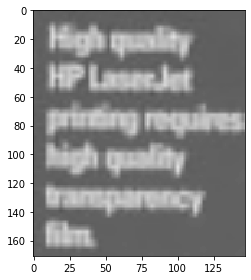

In [139]:
init = np.median(imgs, axis=0)
init = transform.rescale(init, scale, anti_aliasing=False)
io.imshow(np.uint8(init))

In [140]:
X = np.copy(init)
invblur = np.flip(blur)
k = n_img

for i in range(n_iter):
    ML = np.zeros(X.shape)
    h,w = X.shape
    for j in range(k):
        tmpTmat = np.flip(affmats[j]).T
        tmpI = sr.transform(X,tmat=tmpTmat)
        # print(tmpI[0,0])
        ml = sc.signal.convolve2d(tmpI, blur, mode='same')
        # print(ml[0,0])
        x = np.array(range(0,h,scale)).reshape(imgs[j].shape[0],1)
        y = np.array(range(0,w,scale)).reshape(1,imgs[j].shape[1])
        xml = np.sign(ml[x,y] - imgs[j])
        xh,xw = np.int32(xml.shape)
        
        ml = np.zeros((h,w))
        for r in range(xh):
            for c in range(xw):
                ml[r*scale,c*scale] = xml[r,c]
        ml = sc.signal.convolve2d(ml, invblur, mode='same')
        # print(ml[0,0])
        ml = sr.transform(ml,tmat=affmats[j])
        # print(ml[0,0])
        # raise Exception("Lol")
        ML += ml
    print("Iteration",i+1," of ",70,": Cost: ",ML.sum()/k)
    X -= beta*ML

Iteration 1  of  70 : Cost:  -275.5965855408664
Iteration 2  of  70 : Cost:  -279.3102703583799
Iteration 3  of  70 : Cost:  -286.3255465463723
Iteration 4  of  70 : Cost:  -292.54020349827545
Iteration 5  of  70 : Cost:  -292.39602523155156
Iteration 6  of  70 : Cost:  -296.036939181279
Iteration 7  of  70 : Cost:  -296.17354242436613
Iteration 8  of  70 : Cost:  -294.0373475344065
Iteration 9  of  70 : Cost:  -291.6004856238927
Iteration 10  of  70 : Cost:  -290.81172769071264
Iteration 11  of  70 : Cost:  -286.16040393429904
Iteration 12  of  70 : Cost:  -285.41353312718513
Iteration 13  of  70 : Cost:  -280.08693418529236
Iteration 14  of  70 : Cost:  -273.8866132881453
Iteration 15  of  70 : Cost:  -269.45668911541526
Iteration 16  of  70 : Cost:  -266.17000472052194
Iteration 17  of  70 : Cost:  -261.5571800319177
Iteration 18  of  70 : Cost:  -258.5300742967759
Iteration 19  of  70 : Cost:  -255.9978104135799
Iteration 20  of  70 : Cost:  -249.56725680285052
Iteration 21  of  70

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:166: UserWarning: Bi-quadratic interpolation behavior has changed due to a bug in the implementation of scikit-image. The new version now serves as a wrapper around SciPy's interpolation functions, which itself is not verified to be a correct implementation. Until skimage's implementation is fixed, we recommend to use bi-linear or bi-cubic interpolation instead.
  preserve_range=preserve_range)


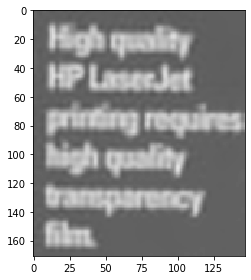

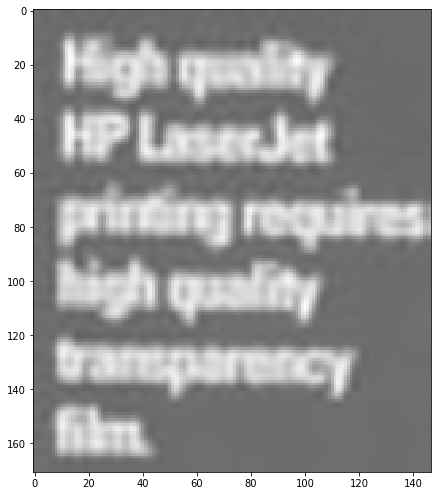

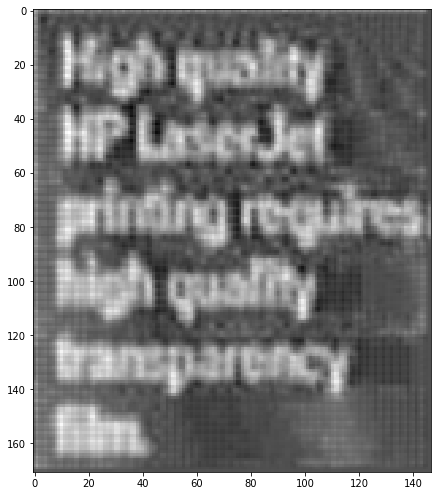

In [142]:
new_img = np.mean(imgs, axis=0)
new_img = transform.rescale(new_img, scale, anti_aliasing=False, order=2)
io.imshow(np.uint8(new_img))
# plt.show()
plt.figure(figsize=(9,7))
io.imshow(np.uint8(new_img/new_img.max()*255))
io.imsave("Mean.bmp",np.uint8(new_img/new_img.max()*255))
plt.show()
plt.figure(figsize=(9,7))
io.imshow(np.uint8(X/X.max()*255))
io.imsave("Affine.bmp",np.uint8(X/X.max()*255))
plt.show()